In [1]:
import os
import json
from openai import OpenAI

os.environ["OPENAI_BASE_URL"] = "http://0.0.0.0:8000/v1" # 替换为本地主机 IP
os.environ["OPENAI_API_KEY"] = "0" 

In [13]:
client = OpenAI()

In [14]:
tools = '[{"name": "sendHttpRequest", "description": "Send an HTTP request with the specified method, headers, and data to the Httpbin API for testing purposes.", "parameters": {"type": "object", "properties": {"method": {"type": "string", "description": "One of: [GET, POST, PUT, DELETE, HEAD, PATCH]. The HTTP method to use (GET, POST, PUT, DELETE, HEAD, or PATCH)."}, "url": {"type": "string", "description": "The endpoint URL to send the request to."}, "headers": {"type": "Object", "description": "A key-value pair of headers to include in the request."}, "data": {"type": "Object", "description": "A key-value pair of data to include in the request body."}}, "required": ["method", "url"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{response: Object{status_code, headers: Object, body}}"}, {"name": "getClientRequestData", "description": "Retrieve the client\'s request data, including headers, form data, uploaded files, and cookies.", "parameters": {"type": "object", "properties": {"url": {"type": "string", "description": "The endpoint URL to send the request to."}}, "required": ["url"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{requestData: Object{headers: Object, form: Object, files: Object, cookies: Object}}"}, {"name": "testProxyHeaders", "description": "Send a request to the Httpbin API\'s proxy headers testing endpoint.", "parameters": {"type": "object", "properties": {"url": {"type": "string", "description": "The endpoint URL to send the request to."}, "headers": {"type": "Object", "description": "A key-value pair of headers to include in the request."}}, "required": ["url"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{response: Object{status_code, headers: Object, body}}"}, {"name": "simulateStatusCode", "description": "Send a request to the Httpbin API\'s status code simulation endpoint to test how your application handles specific status codes.", "parameters": {"type": "object", "properties": {"url": {"type": "string", "description": "The endpoint URL to send the request to."}, "statusCode": {"type": "integer", "description": "The HTTP status code to simulate."}}, "required": ["url", "statusCode"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{response: Object{status_code, headers: Object, body}}"}]'

In [15]:
tools = json.loads(tools)

In [16]:
tools = [{"type": "function", "function": tool} for tool in tools]

In [17]:
messages = []
messages.append({"role": "user", "content": 'I need to test how my app handles a "PATCH" request. Can you send a PATCH request to https://httpbin.org/patch with the data \'{"field": "value"}\' and tell me the response?'})

In [18]:
result = client.chat.completions.create(messages=messages, model="toolalpaca_lora_chatglm3_6b_merged", tools=tools)

In [21]:
result.choices[0].message.content 

'sendHttpRequest\n{"method": "PATCH", "url": "https://httpbin.org/patch", "headers": {}, "data": {"field": "value"}}'

In [10]:
import json
import os 
import re
import ast
from datasets import load_dataset
import matplotlib.pyplot as plt 
import pandas as pd 

In [11]:
# adgen 数据集

In [12]:
with open('AdvertiseGen/dev.json') as f:
    data = [json.loads(line) for line in f]

train_examples = [{
    "content": "你现在是一名销售员，根据以下商品标签生成一段有吸引力的商品广告词: " + x['content'],
    "summary": x['summary'],
} for x in data]


In [13]:
os.makedirs("AdvertiseGen/formatted_data", exist_ok=True)

with open("AdvertiseGen/formatted_data/advertise_dev.json", "w") as f:
    for e in train_examples:
        f.write(json.dumps(e, ensure_ascii=False) + "\n")

In [14]:
with open('AdvertiseGen/dev.json', 'r') as f:
    data = [json.loads(line) for line in f]

In [15]:
data[0]

{'content': '类型#上衣*材质#牛仔布*颜色#白色*风格#简约*图案#刺绣*衣样式#外套*衣款式#破洞',
 'summary': '简约而不简单的牛仔外套，白色的衣身十分百搭。衣身多处有做旧破洞设计，打破单调乏味，增加一丝造型看点。衣身后背处有趣味刺绣装饰，丰富层次感，彰显别样时尚。'}

In [16]:
with open('AdvertiseGen/formatted_data/advertise_dev.json', 'r') as f:
    data = [json.loads(line) for line in f]

In [17]:
data[0]

{'content': '你现在是一名销售员，根据以下商品标签生成一段有吸引力的商品广告词: 类型#上衣*材质#牛仔布*颜色#白色*风格#简约*图案#刺绣*衣样式#外套*衣款式#破洞',
 'summary': '简约而不简单的牛仔外套，白色的衣身十分百搭。衣身多处有做旧破洞设计，打破单调乏味，增加一丝造型看点。衣身后背处有趣味刺绣装饰，丰富层次感，彰显别样时尚。'}

In [18]:
# glaive tool call 数据集

In [19]:
with open('glaive_toolcall_10k.json', 'r') as f:
    data = json.load(f)

In [20]:
data[0]

{'conversations': [{'from': 'human',
   'value': "I saw a dress that I liked. It was originally priced at $200 but it's on sale for 20% off. Can you tell me how much it will cost after the discount?"},
  {'from': 'function_call',
   'value': '{"name": "calculate_discount", "arguments": {"original_price": 200, "discount_percentage": 20}}'},
  {'from': 'observation', 'value': '{"discounted_price": 160}'},
  {'from': 'gpt',
   'value': 'The dress will cost you $160 after the 20% discount.'}],
 'tools': '[{"name": "calculate_discount", "description": "Calculate the discounted price", "parameters": {"type": "object", "properties": {"original_price": {"type": "number", "description": "The original price of the item"}, "discount_percentage": {"type": "number", "description": "The percentage of discount"}}, "required": ["original_price", "discount_percentage"]}}]'}

In [21]:
# tool alpaca数据集

In [22]:
with open('ToolAlpaca/data/formatted_data/tool_alpaca.jsonl', "r", encoding="utf-8") as f:
    if 'formatted_data/tool_alpaca.jsonl'.endswith(".json"):
        train_data = json.load(f)
    elif 'ToolAlpaca/data/formatted_data/tool_alpaca.jsonl'.endswith(".jsonl"):
        train_data = [json.loads(line) for line in f]

In [23]:
train_data[0]

{'tools': ['sendHttpRequest: Send an HTTP request with the specified method, headers, and data to the Httpbin API for testing purposes.\nParameters: {"method": "Required. string. One of: [GET, POST, PUT, DELETE, HEAD, PATCH]. The HTTP method to use (GET, POST, PUT, DELETE, HEAD, or PATCH).", "url": "Required. string. The endpoint URL to send the request to.", "headers": "Object.  A key-value pair of headers to include in the request.", "data": "Object.  A key-value pair of data to include in the request body."}\nOutput: Successful response.\n - Format: application/json\n - Structure: Object{response: Object{status_code, headers: Object, body}}\ngetClientRequestData: Retrieve the client\'s request data, including headers, form data, uploaded files, and cookies.\nParameters: {"url": "Required. string. The endpoint URL to send the request to."}\nOutput: Successful response.\n - Format: application/json\n - Structure: Object{requestData: Object{headers: Object, form: Object, files: Object,

In [24]:
def convert_tools(input_string):
    # Split the input string into separate functions using the pattern
    pattern = r'(.*?):\s(.*?)\nParameters:\s(.*?)\nOutput:\s(.*?)\n\s-\sFormat:\s(.*?)\n\s-\sStructure:\s(.*?)\n'
    functions = re.findall(pattern, input_string, re.DOTALL)
    functions_list = []
    # Iterate over the functions and print them out
    for func in functions:
        tool = {}
        function_name, description, parameters, output, format_type, structure = func
        tool["name"] = function_name
        tool["description"] = description
        parameters_dict = json.loads(parameters)
        required_keys_list = []
        for key in parameters_dict.keys():
            value = parameters_dict[key]
            required_loc = value.find("Required.")
            if required_loc >= 0:
                required_keys_list.append(key)
                value = value[required_loc+9:].strip()
            key_type = value[:value.find('.')].strip()
            key_description = value[value.find('.')+1:].strip()
            new_value = {"type": key_type, "description": key_description}
            parameters_dict[key] = new_value
        tool["parameters"] = {"type": "object", "properties": parameters_dict, "required": required_keys_list}
        tool["output"] = output
        tool["format"] = format_type
        tool["structure"] = structure
        functions_list.append(tool)
    return json.dumps(functions_list)

In [25]:
def format_example(example, tools=None):
    new_example = {}
    if tools:
        new_example['tools'] = json.dumps(tools)
    else:
        new_example['tools'] = convert_tools(example['tools'][0])
    conversations = []
    if isinstance(example['conversations'], str):
        conversations_raw = json.loads(example['conversations'])
    else:
        conversations_raw = example['conversations']
    for item in conversations_raw:
        new_item = {}
        observation = None
        if item['role'] == 'user':
            new_item['from'] = 'human'
            new_item['value'] = item['content']
        elif item['role'] == 'assistant':
            new_item['from'] = 'gpt'
            new_item['value'] = item['content']
        elif item['role'] == 'tool':
            if conversations[-1]['from'] == 'gpt':
                conversations.pop()
            new_item['from'] = 'function_call'
            new_item['value'] = json.dumps({'name': item['name'], 'arguments': item['parameters']})
            if 'observation' in item:
                observation = {'from': 'observation', 'value': item['observation']}
        conversations.append(new_item)
        if observation is not None:
            conversations.append(observation)
    new_example['conversations'] = conversations
    return new_example

In [26]:
def format_example_dev(example, tools=None):
    new_example = {}
    if tools:
        new_example['tools'] = json.dumps(tools)
    else:
        new_example['tools'] = convert_tools(example['tools'][0])
    conversations = []
    if isinstance(example['conversations'], str):
        conversations_raw = json.loads(example['conversations'])
    else:
        conversations_raw = example['conversations']
    for item in conversations_raw:
        new_item = {}
        observation = None
        if item['role'] == 'user':
            new_item['from'] = 'human'
            new_item['value'] = item['content']
        elif item['role'] == 'assistant':
            new_item['from'] = 'gpt'
            new_item['value'] = item['content']
        elif item['role'] == 'tool':
            if conversations[-1]['from'] == 'gpt':
                conversations.pop()
            new_item['from'] = 'function_call'
            new_item['value'] = json.dumps({'name': item['name'], 'arguments': item['parameters']})
            if 'observation' in item:
                observation = {'from': 'observation', 'value': item['observation']}
        conversations.append(new_item)
        if observation is not None:
            conversations.append(observation)
    new_example['conversations'] = conversations[:2]
    return new_example

In [27]:
train_data[0]

{'tools': ['sendHttpRequest: Send an HTTP request with the specified method, headers, and data to the Httpbin API for testing purposes.\nParameters: {"method": "Required. string. One of: [GET, POST, PUT, DELETE, HEAD, PATCH]. The HTTP method to use (GET, POST, PUT, DELETE, HEAD, or PATCH).", "url": "Required. string. The endpoint URL to send the request to.", "headers": "Object.  A key-value pair of headers to include in the request.", "data": "Object.  A key-value pair of data to include in the request body."}\nOutput: Successful response.\n - Format: application/json\n - Structure: Object{response: Object{status_code, headers: Object, body}}\ngetClientRequestData: Retrieve the client\'s request data, including headers, form data, uploaded files, and cookies.\nParameters: {"url": "Required. string. The endpoint URL to send the request to."}\nOutput: Successful response.\n - Format: application/json\n - Structure: Object{requestData: Object{headers: Object, form: Object, files: Object,

In [28]:
train_data_new = []
for i in range(len(train_data)):
    try:
        train_data_new.append(format_example(train_data[i]))
    except:
        pass

In [29]:
dev_data_new = []
for i in range(len(train_data)):
    if i == 100:
        break
    try:
        dev_data_new.append(format_example_dev(train_data[i]))
    except:
        pass

In [30]:
len(train_data_new)

4030

In [31]:
len(dev_data_new)

100

In [20]:
dev_data_new[4]

{'tools': '[{"name": "sendHttpRequest", "description": "Send an HTTP request with the specified method, headers, and data to the Httpbin API for testing purposes.", "parameters": {"type": "object", "properties": {"method": {"type": "string", "description": "One of: [GET, POST, PUT, DELETE, HEAD, PATCH]. The HTTP method to use (GET, POST, PUT, DELETE, HEAD, or PATCH)."}, "url": {"type": "string", "description": "The endpoint URL to send the request to."}, "headers": {"type": "Object", "description": "A key-value pair of headers to include in the request."}, "data": {"type": "Object", "description": "A key-value pair of data to include in the request body."}}, "required": ["method", "url"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{response: Object{status_code, headers: Object, body}}"}, {"name": "getClientRequestData", "description": "Retrieve the client\'s request data, including headers, form data, uploaded files, and cookies.", "parameters"

In [70]:
train_data_new[0]

{'tools': '[{"name": "sendHttpRequest", "description": "Send an HTTP request with the specified method, headers, and data to the Httpbin API for testing purposes.", "parameters": {"type": "object", "properties": {"method": {"type": "string", "description": "One of: [GET, POST, PUT, DELETE, HEAD, PATCH]. The HTTP method to use (GET, POST, PUT, DELETE, HEAD, or PATCH)."}, "url": {"type": "string", "description": "The endpoint URL to send the request to."}, "headers": {"type": "Object", "description": "A key-value pair of headers to include in the request."}, "data": {"type": "Object", "description": "A key-value pair of data to include in the request body."}}, "required": ["method", "url"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{response: Object{status_code, headers: Object, body}}"}, {"name": "getClientRequestData", "description": "Retrieve the client\'s request data, including headers, form data, uploaded files, and cookies.", "parameters"

In [71]:
json.loads(train_data_new[0]['tools'])

[{'name': 'sendHttpRequest',
  'description': 'Send an HTTP request with the specified method, headers, and data to the Httpbin API for testing purposes.',
  'parameters': {'type': 'object',
   'properties': {'method': {'type': 'string',
     'description': 'One of: [GET, POST, PUT, DELETE, HEAD, PATCH]. The HTTP method to use (GET, POST, PUT, DELETE, HEAD, or PATCH).'},
    'url': {'type': 'string',
     'description': 'The endpoint URL to send the request to.'},
    'headers': {'type': 'Object',
     'description': 'A key-value pair of headers to include in the request.'},
    'data': {'type': 'Object',
     'description': 'A key-value pair of data to include in the request body.'}},
   'required': ['method', 'url']},
  'output': 'Successful response.',
  'format': 'application/json',
  'structure': 'Object{response: Object{status_code, headers: Object, body}}'},
 {'name': 'getClientRequestData',
  'description': "Retrieve the client's request data, including headers, form data, uplo

In [72]:
with open('ToolAlpaca/data/formatted_data/tool_alpaca_sharegpt.json', 'w') as file:
    data = json.dump(train_data_new, file)

In [21]:
with open('ToolAlpaca/data/formatted_data/tool_alpaca_dev_sharegpt.json', 'w') as file:
    data_dev = json.dump(dev_data_new, file)

In [73]:
with open('ToolAlpaca/data/formatted_data/tool_alpaca_sharegpt.json', 'r') as f:
    data = json.load(f)

In [74]:
for i in range(len(data)):
    assert data[i] == train_data_new[i]

In [22]:
with open('ToolAlpaca/data/formatted_data/tool_alpaca_dev_sharegpt.json', 'r') as f:
    data_dev = json.load(f)

In [23]:
for i in range(len(data_dev)):
    assert data_dev[i] == dev_data_new[i]

In [75]:
data[0]

{'tools': '[{"name": "sendHttpRequest", "description": "Send an HTTP request with the specified method, headers, and data to the Httpbin API for testing purposes.", "parameters": {"type": "object", "properties": {"method": {"type": "string", "description": "One of: [GET, POST, PUT, DELETE, HEAD, PATCH]. The HTTP method to use (GET, POST, PUT, DELETE, HEAD, or PATCH)."}, "url": {"type": "string", "description": "The endpoint URL to send the request to."}, "headers": {"type": "Object", "description": "A key-value pair of headers to include in the request."}, "data": {"type": "Object", "description": "A key-value pair of data to include in the request body."}}, "required": ["method", "url"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{response: Object{status_code, headers: Object, body}}"}, {"name": "getClientRequestData", "description": "Retrieve the client\'s request data, including headers, form data, uploaded files, and cookies.", "parameters"

In [32]:
a = load_dataset(path='json', data_files='ToolAlpaca/data/formatted_data/tool_alpaca_sharegpt.json')

Generating train split: 0 examples [00:00, ? examples/s]

In [33]:
a['train'][0]

{'tools': '[{"name": "sendHttpRequest", "description": "Send an HTTP request with the specified method, headers, and data to the Httpbin API for testing purposes.", "parameters": {"method": "Required. string. One of: [GET, POST, PUT, DELETE, HEAD, PATCH]. The HTTP method to use (GET, POST, PUT, DELETE, HEAD, or PATCH).", "url": "Required. string. The endpoint URL to send the request to.", "headers": "Object.  A key-value pair of headers to include in the request.", "data": "Object.  A key-value pair of data to include in the request body."}, "output": "Successful response.", "format": "application/json", "structure": "Object{response: Object{status_code, headers: Object, body}}", "required": ["method", "url"]}, {"name": "getClientRequestData", "description": "Retrieve the client\'s request data, including headers, form data, uploaded files, and cookies.", "parameters": {"url": "Required. string. The endpoint URL to send the request to."}, "output": "Successful response.", "format": "ap

In [34]:
a['train'][0] == train_data_new[0]

True

In [373]:
# result analysis 

In [26]:
with open('../toolalpaca_lora/checkpoint-1000/trainer_state.json', 'r') as f:
    train_state = json.load(f)

In [30]:
log_history = train_state['log_history']
steps = [i['step'] for i in log_history]
learning_rate = [i['learning_rate'] for i in log_history]
loss = [i['loss'] for i in log_history]

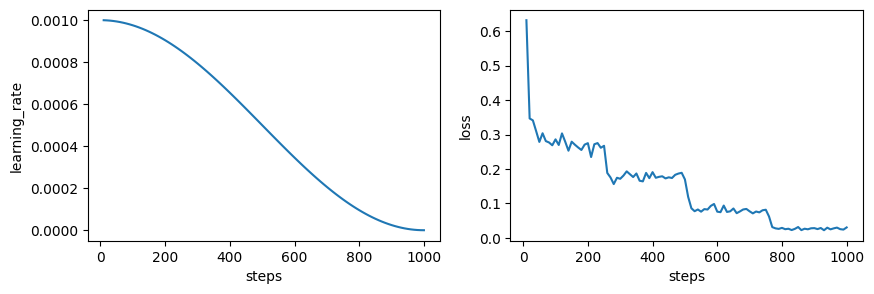

In [37]:
# Create a figure and two subplots, sharing the same y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot data on each axis
ax1.plot(steps, learning_rate)
ax2.plot(steps, loss)

# Optionally, set titles for each subplot
ax1.set_xlabel('steps')
ax1.set_ylabel('learning_rate')
ax2.set_xlabel('steps')
ax2.set_ylabel('loss')

# Show the figure
plt.show()


In [32]:
with open('../outputs/toolalpaca_lora_output_finetune/generated_predictions.jsonl', 'r') as f:
    generated_results = [json.loads(line) for line in f]

In [33]:
with open('../outputs/toolalpaca_lora_output/generated_predictions.jsonl', 'r') as f:
    raw_generated_results = [json.loads(line) for line in f]

In [34]:
def parse_tool_call(input_string):
    # 正则表达式匹配括号内的内容
    args_match = re.search(r".*tool_call\((.*)\).*", input_string)
    if not args_match:
        return "No arguments found."

    # 获取括号内的所有参数字符串
    args_string = args_match.group(1)

    # 使用堆栈来处理嵌套结构
    args_list = []
    stack = []
    last_index = 0
    for i, char in enumerate(args_string):
        if char == '{':
            stack.append(char)
        elif char == '}':
            stack.pop()
        elif char == ',' and not stack:
            # 当遇到逗号且堆栈为空时，表示这是一个顶级参数的分隔符
            args_list.append(args_string[last_index:i])
            last_index = i + 2  # 跳过逗号和空格

    # 添加最后一个参数到列表中
    args_list.append(args_string[last_index:])

    # 解析每个参数为键值对，并存储在字典中
    args_dict = {}
    try:
        for arg in args_list:
            key, value = arg.split('=', 1)
            args_dict[key.strip()] = ast.literal_eval(value.strip())
    except:
        pass

    return args_dict

In [35]:
def parse_action_input(input_string):
    # 使用正则表达式提取 Action 和 Action Input
    action_match = re.search(r'Action: (\w+)', input_string)
    action_input_match = re.search(r'Action Input:.*(\{.*\})', input_string)
    
    # 检查是否找到匹配项并提取
    action = action_match.group(1) if action_match else None
    action_input = json.loads(action_input_match.group(1)) if action_input_match else None
    return action, action_input

In [36]:
def format_prediction(input_string):
    input_string = input_string.strip()
    split = input_string.find('\n')
    if split >= 0:
        intent = input_string[:split].strip()
        method_string = input_string[split+1:].strip()
        if method_string.find('tool_call') >= 0:
            slot = parse_tool_call(method_string)
        elif (method_string.find('Action') >= 0) and (method_string.find('Action Input') >= 0):
            intent, slot = parse_action_input(method_string)
        else:
            slot = json.loads(input_string[split+1:].strip())
    else:
        intent = ''
        slot = {}
    return intent, slot

def cal_metric(label, prediction):
    target_intent, target_method = format_prediction(label)
    prediction_intent, prediction_method = format_prediction(prediction)
    if prediction_intent == target_intent:
        if prediction_method == target_method:
            result = [1, 1]
        else:
            result = [1, 0]
    else:
        result = [0, 0]
    return result 

In [37]:
def cal_lora(generated_results, model_name, set_name):
    print(model_name, set_name)
    results = []
    for i in range(len(generated_results)):
        label = generated_results[i]['label']
        prediction =  generated_results[i]['predict']
        try:
            result = cal_metric(label, prediction)
        except:
            print('oops', i)
        result += [dev_data_new[i]['conversations'][0]['value'], label, prediction]
        results.append(result)
    results = pd.DataFrame(results)
    results.columns = ['intent', 'slot', 'query', 'target', 'prediction']
    results['model_name'] = model_name
    results['set_name'] = set_name
    results = results.reset_index()
    return results 

In [38]:
def cal_accuracy(results):
    num = results.shape[0]
    intent = results['intent']
    zero_error_count = intent.shape[0]
    zero_error_rate = 1
    intent_sum, intent_mean = intent.sum(), intent.mean()
    slot = results[(results['intent'] == 1)]['slot']
    slot_sum, slot_mean = slot.sum(), slot.mean()
    both_mean = slot_sum / zero_error_count
    return pd.Series([num, zero_error_count, zero_error_rate, intent_sum, intent_mean, slot_sum, slot_mean, both_mean],
                     index=['num', 'zero_error_count', 'zero_error_rate', 'intent_sum', 'intent_mean', 'slot_sum', 'slot_mean', 'both_mean'])

In [39]:
final = []
final.append(cal_lora(generated_results, '1finetune', '1train'))
final.append(cal_lora(raw_generated_results, '2raw', '1train'))
final = pd.concat(final, axis=0)
final = final.reset_index(drop=True)

1finetune 1train
2raw 1train


In [40]:
final.groupby(['model_name', 'set_name']).apply(cal_accuracy)

,,num,zero_error_count,zero_error_rate,intent_sum,intent_mean,slot_sum,slot_mean,both_mean
model_name,set_name,,,,,,,,
1finetune,1train,100.0,100.0,1.0,98.0,0.98,97.0,0.989796,0.97
2raw,1train,100.0,100.0,1.0,71.0,0.71,41.0,0.577465,0.41


In [42]:
for i in range(final[(final['model_name']=='1finetune') & ((final['intent']==0) | (final['slot']==0))].shape[0]):
    print('index:', final[(final['model_name']=='1finetune') & ((final['intent']==0) | (final['slot']==0))].iloc[i]['index'])
    print('query:', final[(final['model_name']=='1finetune') & ((final['intent']==0) | (final['slot']==0))].iloc[i]['query'])
    print('target:', final[(final['model_name']=='1finetune') & ((final['intent']==0) | (final['slot']==0))].iloc[i]['target'])
    print('prediction:', final[(final['model_name']=='1finetune') & ((final['intent']==0) | (final['slot']==0))].iloc[i]['prediction'])

index: 17
query: I've heard there was a thunderstorm last night in Miami, Florida, with coordinates 25.7617, -80.1918. Can you show me its radar data from yesterday?
target: getRadarData
{"latitude": 25.7617, "longitude": -80.1918, "date": "2020-08-20"}
prediction: getRadarData
{"latitude": 25.7617, "longitude": -80.1918, "date": "2020-08-12"}
index: 46
query: My friend is going to Tenerife next week. What can they expect in terms of weather? Please provide the forecast for the next 7 days, including temperature, precipitation, humidity, and wind speed.
target: getWeatherForecast
{"location": "Tenerife", "days": 7}
prediction: searchLocation
{"query": "Tenerife"}
index: 68
query: I've found a job at a company called DreamTech that I'm really interested in. Can you please provide me with more details about this job posting, like the salary, requirements, and application instructions?
target: searchJobPostings
{"company": "DreamTech"}
prediction: getJobPostingDetails
{"jobId": "12345"}


In [45]:
for i in range(final[(final['model_name']=='2raw') & ((final['intent']==0) | (final['slot']==0))].shape[0]):
    print('index:', final[(final['model_name']=='2raw') & ((final['intent']==0) | (final['slot']==0))].iloc[i]['index'])
    print('query:', final[(final['model_name']=='2raw') & ((final['intent']==0) | (final['slot']==0))].iloc[i]['query'])
    print('target:', final[(final['model_name']=='2raw') & ((final['intent']==0) | (final['slot']==0))].iloc[i]['target'])
    print('prediction:', final[(final['model_name']=='2raw') & ((final['intent']==0) | (final['slot']==0))].iloc[i]['prediction'])

index: 2
query: I have a feeling that some proxy headers aren't being passed correctly. Can you send a request to https://httpbin.org/headers with the headers "X-Forwarded-For: 192.168.1.1" and "X-Real-IP: 10.0.0.1"? I'd like to verify if the headers are properly forwarded by the proxy.
target: sendHttpRequest
{"method": "GET", "url": "https://httpbin.org/headers", "headers": {"X-Forwarded-For": "192.168.1.1", "X-Real-IP": "10.0.0.1"}}
prediction: testProxyHeaders
 ```python
tool_call(url='https://httpbin.org/headers', headers={'X-Forwarded-For': '192.168.1.1', 'X-Real-IP': '10.0.0.1'})
```
index: 3
query: I'd like to see how my application responds to a 404 status code. Please send a request to https://httpbin.org/status/404 and let me know the details of the received status code and response headers.
target: simulateStatusCode
{"url": "https://httpbin.org/status/404", "statusCode": 404}
prediction: simulateStatusCode
 ```python
tool_call(url='https://httpbin.org/status/404')
```
inde

In [23]:
# 部署

In [22]:
# python src/export_model.py \
#     --model_name_or_path /data/dataset/huggingface/hub/chatglm3-6b \
#     --adapter_name_or_path models/toolalpaca_lora/checkpoint-1000 \
#     --template chatglm3 \
#     --finetuning_type lora \
#     --export_dir models/toolalpaca_lora_chatglm3_6b_merged \
#     --export_size 2 \
#     --export_legacy_format False
# python -m src.llmtuner.api.app --model_name_or_path models/toolalpaca_lora_chatglm3_6b_merged --template chatglm3
import os
import json
from openai import OpenAI

os.environ["OPENAI_BASE_URL"] = "http://0.0.0.0:8000/v1"  # 替换为本地主机 IP
os.environ["OPENAI_API_KEY"] = "0"
client = OpenAI()
tools = '[{"name": "sendHttpRequest", "description": "Send an HTTP request with the specified method, headers, and data to the Httpbin API for testing purposes.", "parameters": {"type": "object", "properties": {"method": {"type": "string", "description": "One of: [GET, POST, PUT, DELETE, HEAD, PATCH]. The HTTP method to use (GET, POST, PUT, DELETE, HEAD, or PATCH)."}, "url": {"type": "string", "description": "The endpoint URL to send the request to."}, "headers": {"type": "Object", "description": "A key-value pair of headers to include in the request."}, "data": {"type": "Object", "description": "A key-value pair of data to include in the request body."}}, "required": ["method", "url"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{response: Object{status_code, headers: Object, body}}"}, {"name": "getClientRequestData", "description": "Retrieve the client\'s request data, including headers, form data, uploaded files, and cookies.", "parameters": {"type": "object", "properties": {"url": {"type": "string", "description": "The endpoint URL to send the request to."}}, "required": ["url"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{requestData: Object{headers: Object, form: Object, files: Object, cookies: Object}}"}, {"name": "testProxyHeaders", "description": "Send a request to the Httpbin API\'s proxy headers testing endpoint.", "parameters": {"type": "object", "properties": {"url": {"type": "string", "description": "The endpoint URL to send the request to."}, "headers": {"type": "Object", "description": "A key-value pair of headers to include in the request."}}, "required": ["url"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{response: Object{status_code, headers: Object, body}}"}, {"name": "simulateStatusCode", "description": "Send a request to the Httpbin API\'s status code simulation endpoint to test how your application handles specific status codes.", "parameters": {"type": "object", "properties": {"url": {"type": "string", "description": "The endpoint URL to send the request to."}, "statusCode": {"type": "integer", "description": "The HTTP status code to simulate."}}, "required": ["url", "statusCode"]}, "output": "Successful response.", "format": "application/json", "structure": "Object{response: Object{status_code, headers: Object, body}}"}]'
tools = json.loads(tools)
tools = [{"type": "function", "function": tool} for tool in tools]
messages = []
messages.append({"role": "user",
                 "content": 'I need to test how my app handles a "PATCH" request. Can you send a PATCH request to https://httpbin.org/patch with the data \'{"field": "value"}\' and tell me the response?'})
result = client.chat.completions.create(messages=messages, model="toolalpaca_lora_chatglm3_6b_merged", tools=tools)
result.choices[0].message.content 

'sendHttpRequest\n{"method": "PATCH", "url": "https://httpbin.org/patch", "headers": {}, "data": {"field": "value"}}'